In [ ]:
#Cambios con respecto a SimulationTest2: cambio de la función de generar ruta
#pasa de la original a una buscada en internet que funciona el 80% de las veces
#Esta función ya no crea todas las rutas posibles sino que sólo crea 1 ruta
#Basada en el algoritmo a*

In [1069]:
# Import general
import pandas as pd
import numpy as np
import array

# Import para mapa
from matplotlib import pyplot
from matplotlib import colors
import pickle

# Import para clases
from abc import ABC

# Import para generar ruta
import copy

# Import para generar pedido
import random

In [1070]:
# Clases

class Robot(ABC):
    def __init__(self, ID: int, vel: float, pedidos: int, ruta):
        self._ID = ID  # ID del robot
        self._vel: float = vel  # Velocidad del robot
        self._pos = 0  # Posición en matriz array, es un vector
        self._pedidos: int = pedidos  # Número de pedidos máximos del robot
        self._ruta = ruta  # Array de Arrays
        self._vol = 0.0  # Volumen máximo de capacidad
        self._pesomax = 0.0  # Peso máximo de capacidad

        self._proceso: int = 0  # Proceso que se encuentra el robot
        # 0: espera, 1: movimiento, 2: entrega

        self._dist: float = 0.0  # Distancia recorrida por el robot
        self._inter: int = 0  # Intersecciones entre robots encontradas
        self._tiempoespera: float = 0.0  # Tiempo del robot esperando

    def get_ID(self) -> int:
        return self._ID

    def set_ID(self, ID: int):
        self._ID = ID

    def get_vel(self) -> float:
        return self._vel

    def set_vel(self, vel: float):
        if vel > 0:
            self._vel = vel

    def get_pos(self):
        return self._pos

    def set_pos(self, pos):
        self._pos = pos

    def get_pedidos(self) -> int:
        return self._pedidos

    def set_pedidos(self, pedidos: int):
        if pedidos == 6 or pedidos == 12:
            self._pedidos = pedidos

    def get_vol(self) -> float:
        return self._vol

    def set_vol(self, vol: float):
        if vol > 0:
            self._vol = vol

    def get_pesomax(self) -> float:
        return self._pesomax

    def set_pesomax(self, pesomax: float):
        if pesomax > 0:
            self._pesomax = pesomax 

    def get_proceso(self) -> int:
        return self._proceso

    def set_proceso(self, proceso: int):
        if proceso >= 0 and proceso <= 3:
            self._proceso = proceso

    def get_ruta(self) -> array.array:
        return self._ruta

    def set_ruta(self, ruta: array.array):
        self._ruta = ruta

    def get_dist(self) -> float:
        return self._dist

    def set_dist(self, dist: float):
        if dist > 0:
            self._dist = dist

    def get_inter(self) -> int:
        return self._inter

    def set_inter(self, inter: int):
        if inter > 0:
            self._inter = inter

    def get_tiempoespera(self) -> float:
        return self._tiempoespera

    def set_tiempoespera(self, tiempoespera: float):
        if tiempoespera > 0:
            self._tiempoespera = tiempoespera


class Humano(ABC):
    def __init__(self, ID: int, vel: float, picktime: float):
        self._ID = ID  # ID del humano
        self._pos: float = 0.0  # Posición del humano en matriz
        self._vel: float = 0.0  # Velocidad del humano
        self._picktime: float = 15.0  # Tiempo que tarda en hacer el pick

        self._proceso: int = 0  # Proceso en el que está el humano
        # 0: parado, 1: pedido, 3: picking, 4: regreso

        self._modo: str = "espera"  # Modo en el que está

    def get_ID(self) -> int:
        return self._ID

    def set_ID(self, ID: int):
        self._ID = ID

    def get_vel(self) -> float:
        return self._vel

    def set_vel(self, vel: float):
        if vel > 0:
            self._vel = vel

    def get_pos(self):
        return self._pos

    def set_pos(self, pos):
        self._pos = pos

    def get_picktime(self) -> float:
        return self._picktime

    def set_picktime(self, picktime: float):
        if picktime > 0:
            self._picktime = picktime

    def get_proceso(self) -> int:
        return self._proceso

    def set_proceso(self, proceso: int):
        if proceso >= 0 and proceso <= 4:
            self._proceso = proceso

    def get_modo(self) -> str:
        return self._modo

    def set_modo(self, modo: str):
        self._modo = modo

    


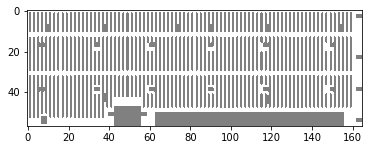

In [1071]:
# Mapa Layout SPF

map_SPF = np.ones((57, 165), dtype=int)

for i in range(map_SPF.shape[1]):
    if (i % 2) == 0:
        map_SPF[:, i] = 0

map_SPF[0, :] = 0  # Fila 0 vacia
map_SPF[11:13, :] = 0  # Fila gruesa vacia
map_SPF[30:32, :] = 0  # Fila gruesa vacia
map_SPF[:, 160:165] = 0  # Columna gruesa final vacia
map_SPF[53:57, 0:38] = 0  # Zona inferior izquierda vacia
map_SPF[48:57, 38:42] = 0  #
map_SPF[43:47, 42:57] = 0  #
map_SPF[47:57, 43:55] = 1  # Hueco ocupado "exterior"
map_SPF[48:57, 56:63] = 0  #
map_SPF[48:50, 63:156] = 0  # Filas que separan la zona de recogida vacias
map_SPF[48:57, 156:164] = 0  #
map_SPF[50:57, 63:156] = 1  # Zona de recogida ocupada
map_SPF[51, 7:10] = 0  # Hueco encima de una escalera
# Huecos intercalados:
map_SPF[16:20, 32:37] = 0  # Hueco a
map_SPF[16:20, 58:63] = 0  # Hueco b
map_SPF[16:20, 88:93] = 0  # Hueco e
map_SPF[16:20, 114:119] = 0  # Hueco g
map_SPF[16:20, 146:151] = 0  # Hueco i
map_SPF[37:41, 32:37] = 0  # Hueco d
map_SPF[37:41, 58:63] = 0  # Hueco c
map_SPF[37:41, 88:93] = 0  # Hueco f
map_SPF[37:41, 114:119] = 0  # Hueco h
map_SPF[37:41, 146:151] = 0  # Hueco j
# Escaleras:
map_SPF[7:11, 10:12] = 1  #
map_SPF[7:11, 38:40] = 1  #
map_SPF[7:11, 74:76] = 1  #
map_SPF[7:11, 90:92] = 1  #
map_SPF[7:11, 118:120] = 1  #
map_SPF[7:11, 154:156] = 1  #
map_SPF[52:56, 7:10] = 1  #
map_SPF[41:45, 38:40] = 1  #
map_SPF[42:46, 118] = 1  #
# Cuadrados azules derecha:
map_SPF[2:4, 162:165] = 1  #
map_SPF[22:24, 162:165] = 1  #
map_SPF[38:40, 162:165] = 1  #
map_SPF[53:55, 162:165] = 1  #
# Cuadrados azules abajo:
map_SPF[50:52, 40:43] = 1  #
map_SPF[50:52, 56:59] = 1  #
# Columnas verdes:
map_SPF[16:18, 6:9] = 1  #
map_SPF[16:18, 33:36] = 1  #
map_SPF[16:18, 60:63] = 1  #
map_SPF[16:18, 89:92] = 1  #
map_SPF[16:18, 116:119] = 1  #
map_SPF[16:18, 149:152] = 1  #
map_SPF[38:40, 6:9] = 1  #
map_SPF[38:40, 33:36] = 1  #
map_SPF[38:40, 60:63] = 1  #
map_SPF[38:40, 89:92] = 1  #
map_SPF[38:40, 116:119] = 1  #
map_SPF[38:40, 149:152] = 1  #


list_SPF = map_SPF.tolist()


# Escritura en modo binario, vacía el fichero si existe
fichero = open("mapaTarancon_P1.pckl", "wb")

# Escribe la colección en el fichero
pickle.dump(list_SPF, fichero)

fichero.close()

"""
# Lectura en modo binario
fichero = open("mapaTarancon_P1.pckl", "rb")

# Cargamos los datos del fichero
lista_fichero = pickle.load(fichero)

fichero.close()
"""

colormap = colors.ListedColormap(["white", "grey"])
# entregando este problema a
pyplot.imshow(list_SPF, cmap=colormap)
pyplot.show()

In [1072]:
# Función Generar Pedido

def generar_pedido():

    y = 0

    # y es el valor que establece si el vector es correcto o no 
    # 0: incorrecto, 1: Correcto

    while y == 0:

        num1 = random.randint(1, 55) # Valor random del eje x
        num2 = random.randint(1, 158) # Valor random del eje y

        x = 0 
        
        """x es el número de "0" que hay en las 9 posiciones contiguas a la
        selección. Si hay 4 o menos "0", la selección será válida
        (ya que no está en los pasillos). Si hay más de 4 "0" significa que
        está en un pasillo u otro espacio en el que no hay estantería"""

        # Comprueba las 9 casillas contiguas en las que hay "0"

        if map_SPF[num1 + 1, num2] == 0:
            x = x + 1

        if map_SPF[num1 + 1, num2 + 1] == 0:
            x = x + 1

        if map_SPF[num1, num2 + 1] == 0:
            x = x + 1

        if map_SPF[num1 - 1, num2 + 1] == 0:
            x = x + 1

        if map_SPF[num1 - 1, num2] == 0:
            x = x + 1

        if map_SPF[num1 - 1, num2 - 1] == 0:
            x = x + 1

        if map_SPF[num1, num2 - 1] == 0:
            x = x + 1

        # Comprueba que la posición está libre y hay 4 o menos casillas con "0"
        if x <= 4 and map_SPF[num1, num2] == 0:
            y = 1
            vector = np.array([num1, num2])

        # Caso en el que la selección no es válida
        if x > 4 or map_SPF[num1, num2] == 1:
            y = 0

        print("Vector [",num1, ",",num2,"]")
        print("Valor Matriz: ", map_SPF[num1, num2])

    return num1, num2

In [1073]:
# Función Calcular Ruta (A*)

class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


def astar(maze, start, end):
    """Returns a list of tuples as a path from the given start to the given end in the given maze"""

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1] # Return reversed path

        # Generate children
        children = []
        #for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]: # Adjacent squares
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]: # Adjacent squares

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue

            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2)
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)


In [1074]:
# Función Comprobar Ruta

def ComprobarRuta(route):
    """
    La idea es que reciba una ruta en forma de lista con coordenadas.
    Se sabe que la velocidad del robot es 0.9 m/s y se ha considerado que cada casilla mide 1.3X1.3 m^2.
    Así, se podrá saber, por tiempo, cuándo pasa el robot de una coordenada a otra, liberando las casillas.

    De momento, se considera que la ruta que se recibe ocupa todas las casillas en el momento de la comprobación.
    """
    ruta = route

    for indice, coordenada in enumerate(ruta):
        # Comprobar que la ruta es factible -> que cada coordenada es un 0 en la matriz
        x = coordenada[0]
        y = coordenada[1]
        if map_SPF[x, y] != 0:
            print("Error. La ruta no es factible.")
            return 0 # No funciona
            break

        else:
            index_ruta = indice
    
    # Create a new map
    #map_SPF_copy = copy.copy(map_SPF)

    if (index_ruta + 1) == len(ruta):
        # Significa que toda la ruta es válida. Se ordena al robot que la ejecute.
        print("Ruta Correcta")
        for coordenada in ruta:
            x = coordenada[0]
            y = coordenada[1]
            map_SPF[x, y] = 2  # El robot ocupa las coordenadas de la ruta


        # Descomentar lo siguiente para guardar de verdad el nuevo plano en el fichero:
        list_SPF = map_SPF.tolist()
        # Escritura en modo binario, vacía el fichero si existe
        fichero = open("mapaTarancon_P1.pckl", "wb")
        # Escribe la colección en el fichero
        pickle.dump(list_SPF, fichero)
        fichero.close()
        colormap = colors.ListedColormap(["white", "grey", "red"])
        # entregando este problema a
            
        pyplot.imshow(list_SPF, cmap=colormap)
        pyplot.show()

        return 1


In [1075]:
# Función Recopilar

"""Script para guardar todos los datos deseados:

- Tiempos del robot:
    - Journey (Llegada)
    - Waiting (Espera)
    - Hand Picking (Parada)
- Ruta del robot
- Destino
- Velocidad (para comprobar que son 0,9s)
- Número de Totes (6 o 12)
- ID del robot
- Número de artículos recogidos
- Número de pedidos completados
"""

"""
import string
from typing import List
"""

"""
https://stackabuse.com/reading-and-writing-csv-files-in-python-with-pandas/
https://www.statology.org/pandas-to-csv-append/
"""
import pandas as pd


def create_data_CSV(
    Journey,
    Waiting,
    HandPicking,
    Route,
    Destination,
    Speed,
    NumTotes,
    ID,
    PickedItems,
    CompletedOrders,
):

    """This function creates a NEW CSV with the given data"""

    colum_names = [
        "Journey Time",
        "Waiting Time",
        "Hand Picking Time",
        "Route",
        "Destination",
        "Speed",
        "Num Totes",
        "ID",
        "Picked Items",
        "Completed Orders",
    ]

    dataArray = [
        Journey,
        Waiting,
        HandPicking,
        Route,
        Destination,
        Speed,
        NumTotes,
        ID,
        PickedItems,
        CompletedOrders,
    ]

    data = pd.DataFrame(
        [dataArray],
        columns=colum_names,
    )
    data.to_csv(
        # "D:\\ICAI\\CICLAB\\CICLAB ID Logistics\\data.csv",
        "data.csv",
        mode="w",
        index=False,
        na_rep="Unknown",
    )


def update_data_CSV(
    Journey,
    Waiting,
    HandPicking,
    Route,
    Destination,
    Speed,
    NumTotes,
    ID,
    PickedItems,
    CompletedOrders,
):

    """This function UPDATES the existing CSV with the given data"""

    dataArrayforUpdate = [
        Journey,
        Waiting,
        HandPicking,
        Route,
        Destination,
        Speed,
        NumTotes,
        ID,
        PickedItems,
        CompletedOrders,
    ]

    dataUpdate = pd.DataFrame([dataArrayforUpdate])
    dataUpdate.to_csv(
        # "D:\\ICAI\\CICLAB\\CICLAB ID Logistics\\data.csv",
        "data.csv",
        mode="a",
        index=False,
        na_rep="Unknown",
        header=False,
    )



**MAIN**

Vector [ 43 , 157 ]
Valor Matriz:  1
Vector [ 4 , 76 ]
Valor Matriz:  0
Vector [ 9 , 27 ]
Valor Matriz:  1
Vector [ 34 , 132 ]
Valor Matriz:  0
[ 4 76 ] [ 34 132 ]
[(4, 76), (5, 76), (6, 76), (7, 76), (8, 76), (9, 76), (10, 76), (11, 76), (11, 77), (11, 78), (11, 79), (11, 80), (11, 81), (11, 82), (11, 83), (11, 84), (11, 85), (11, 86), (11, 87), (11, 88), (11, 89), (11, 90), (11, 91), (11, 92), (11, 93), (11, 94), (11, 95), (11, 96), (11, 97), (11, 98), (11, 99), (11, 100), (11, 101), (11, 102), (11, 103), (11, 104), (11, 105), (11, 106), (11, 107), (11, 108), (11, 109), (11, 110), (12, 110), (12, 111), (12, 112), (13, 112), (14, 112), (15, 112), (16, 112), (17, 112), (18, 112), (19, 112), (20, 112), (21, 112), (22, 112), (23, 112), (24, 112), (25, 112), (26, 112), (27, 112), (28, 112), (29, 112), (30, 112), (30, 113), (30, 114), (30, 115), (30, 116), (30, 117), (30, 118), (30, 119), (30, 120), (30, 121), (30, 122), (30, 123), (30, 124), (30, 125), (30, 126), (30, 127), (30, 128), (30

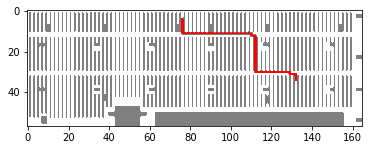

[(4, 76), (5, 76), (6, 76), (7, 76), (8, 76), (9, 76), (10, 76), (11, 76), (11, 77), (11, 78), (11, 79), (11, 80), (11, 81), (11, 82), (11, 83), (11, 84), (11, 85), (11, 86), (11, 87), (11, 88), (11, 89), (11, 90), (11, 91), (11, 92), (11, 93), (11, 94), (11, 95), (11, 96), (11, 97), (11, 98), (11, 99), (11, 100), (11, 101), (11, 102), (11, 103), (11, 104), (11, 105), (11, 106), (11, 107), (11, 108), (11, 109), (11, 110), (12, 110), (12, 111), (12, 112), (13, 112), (14, 112), (15, 112), (16, 112), (17, 112), (18, 112), (19, 112), (20, 112), (21, 112), (22, 112), (23, 112), (24, 112), (25, 112), (26, 112), (27, 112), (28, 112), (29, 112), (30, 112), (30, 113), (30, 114), (30, 115), (30, 116), (30, 117), (30, 118), (30, 119), (30, 120), (30, 121), (30, 122), (30, 123), (30, 124), (30, 125), (30, 126), (30, 127), (30, 128), (30, 129), (31, 129), (31, 130), (31, 131), (31, 132), (32, 132), (33, 132), (34, 132)]
CPU times: user 213 ms, sys: 35 ms, total: 248 ms
Wall time: 154 ms


In [1076]:
%%time

num1, num2 = generar_pedido()
num3, num4 = generar_pedido()

#print vector
print("[",num1, num2, "]", "[",num3, num4, "]")

path = astar(map_SPF, (num1,num2), (num3,num4))
print(path)

comprobacion = ComprobarRuta(path)
print(path)
